<a href="https://colab.research.google.com/github/ruthtsai/Deep-Generative-Models/blob/main/HW4_%E6%99%82%E9%96%93%E5%BA%8F%E5%88%97_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Setup 與 Data Import - 環境與全域參數設定

In [14]:
!pip install yfinance pandas_ta -q
!pip install --upgrade scikit-learn -q

In [15]:
import os
import math
import copy
import random
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import pandas_ta as ta
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
from tqdm.notebook import tqdm

2. 參數設定 (Configuration)

In [16]:
# 隨機種子
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


TICKER = '2330.TW'
START = '2000-01-01'
END = '2024-12-31'
LOOKBACK = 30
BATCH_SIZE = 64
EPOCHS = 30
SPLIT_RATIOS = [0.8, 0.1, 0.1]
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# LSTM
LSTM_LR = 1e-4
LSTM_HIDDEN = 128
LSTM_NUM_LAYERS = 1
LSTM_DROPOUT = 0.1

# TRANSFORMER
TRANSFORMER_LR = 3e-4
TRANSFORMER_WEIGHT_DECAY = 1e-4
TRANSFORMER_DMODEL = 128
TRANSFORMER_NHEAD = 4
TRANSFORMER_FFN = 256
TRANSFORMER_LAYERS = 2
DROPOUT = 0.1

print(f"Using device: {DEVICE}")

Using device: cuda


3. 資料前處理 輔助函數

In [17]:
def calculate_indicators_to_df(df):
    """
    計算所有技術指標並將它們作為新欄位"加入"到傳入的 DataFrame 中。
    """
    df_feat = df.copy()

    # 趨勢型
    if len(df_feat) > 5: df_feat['SMA_5'] = ta.sma(df_feat['Close'], length=5)
    else: df_feat['SMA_5'] = np.nan

    if len(df_feat) > 20: df_feat['SMA_20'] = ta.sma(df_feat['Close'], length=20)
    else: df_feat['SMA_20'] = np.nan

    # 長度檢查
    if len(df_feat) > 35:
        macd = ta.macd(df_feat['Close'])
        #
        if macd is not None and not macd.empty:
            df_feat['MACD'] = macd['MACD_12_26_9']
            df_feat['MACD_SIGNAL'] = macd['MACDs_12_26_9']
            df_feat['MACD_HIST'] = macd['MACDh_12_26_9']
        else:
            print("Warning: ta.macd() returned None or Empty, skipping MACD features.")
            df_feat['MACD'] = np.nan
            df_feat['MACD_SIGNAL'] = np.nan
            df_feat['MACD_HIST'] = np.nan
    else:
        print(f"Warning: DataFrame length ({len(df_feat)}) too short for MACD, skipping.")
        df_feat['MACD'] = np.nan
        df_feat['MACD_SIGNAL'] = np.nan # (v4.1 fix)
        df_feat['MACD_HIST'] = np.nan

    # 震盪型
    if len(df_feat) > 14: df_feat['RSI_14'] = ta.rsi(df_feat['Close'], length=14)
    else: df_feat['RSI_14'] = np.nan

    # 波動型
    if len(df_feat) > 10: df_feat['ROLL_STD_10'] = df_feat['Close'].rolling(10).std()
    else: df_feat['ROLL_STD_10'] = np.nan

    # 量能型
    if len(df_feat) > 10: df_feat['VOL_MA_10'] = df_feat['Volume'].rolling(10).mean()
    else: df_feat['VOL_MA_10'] = np.nan

    return df_feat

def create_sequences(features_scaled, target_scaled, lookback=30):
    """
    從 (已縮放的) numpy 陣列建立序列
    (採用 hw4_時間序列.py 的 create_sequences 邏輯)
    """
    X, y = [], []
    for i in range(lookback - 1, len(features_scaled)):
        X.append(features_scaled[i - lookback + 1 : i + 1])
        y.append(target_scaled[i])

    return np.array(X), np.array(y)

4. PyTorch Dataset

In [18]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

5. 模型定義

In [19]:
# --- 5.1 Baseline: LSTM ---
#
class LSTMModel(nn.Module):
    def __init__(self, n_features, hidden=128, num_layers=1, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden,
            num_layers=1, # HW7
            batch_first=True,
            dropout=dropout
        )
        self.layernorm = nn.LayerNorm(hidden)
        self.fc = nn.Linear(hidden, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_time_step_out = lstm_out[:, -1, :]
        out = self.layernorm(last_time_step_out)
        out = self.fc(out)
        return out

# --- 5.2 Transformer ---

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        max_len = int(max_len)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class TransformerEncoderModel(nn.Module):
    def __init__(self, n_features, d_model=128, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.nhead = nhead

        self.input_proj = nn.Linear(n_features, d_model)
        self.pos_enc = PositionalEncoding(d_model, dropout)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model, nhead, dim_feedforward, dropout,
            activation='relu',
            batch_first=True,
            norm_first=True  # 【修正】從 False 改為 True (統一為 Pre-Norm)
        )
        self.encoder_layers = nn.ModuleList([copy.deepcopy(encoder_layer) for _ in range(num_layers)])

        self.out = nn.Linear(d_model, 1)
        self.attention_weights = None

    def forward(self, x):
        x = self.input_proj(x)
        x = self.pos_enc(x)

        for i, layer in enumerate(self.encoder_layers):
            if i == self.num_layers - 1:
                # 手動實現最後一層的 Pre-Norm (norm_first=True)
                # 以便獲取 attention_weights

                # 1. Pre-Norm + Self-Attention
                x_norm = layer.norm1(x)

                sa_output, attn_weights = layer.self_attn(
                    x_norm, x_norm, x_norm,
                    need_weights=True,
                    average_attn_weights=False
                )

                self.attention_weights = attn_weights.detach().cpu()

                # Residual 1
                x = x + layer.dropout1(sa_output)

                # 2. Pre-Norm + FFN
                x_norm_ff = layer.norm2(x)
                ff_output = layer.linear2(layer.dropout(layer.activation(layer.linear1(x_norm_ff))))

                # Residual 2
                x = x + layer.dropout2(ff_output)

            else:
                # 其他層 (第 0 到 N-2 層)
                # 因為 norm_first=True，這裡會自動執行 Pre-Norm
                x = layer(x)

        # Pooling
        pooled = x.mean(dim=1)
        pred = self.out(pooled)
        return pred

6. 訓練與評估

In [20]:
def train_one_epoch(model, loader, optimizer, criterion, device, scheduler=None):
    model.train()
    running_loss = 0.0
    for Xb, yb in loader:
        Xb = Xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()

        preds = model(Xb)
        loss = criterion(preds, yb)

        loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step()

        running_loss += loss.item() * Xb.size(0)

    return running_loss / len(loader.dataset)


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    preds_list = []
    ys_list = []

    with torch.no_grad():
        for Xb, yb in loader:
            Xb = Xb.to(device)
            yb = yb.to(device)

            preds = model(Xb)

            running_loss += criterion(preds, yb).item() * Xb.size(0)
            preds_list.append(preds.detach().cpu().numpy())
            ys_list.append(yb.detach().cpu().numpy())

    preds_all = np.vstack(preds_list)
    ys_all = np.vstack(ys_list)

    return running_loss / len(loader.dataset), preds_all, ys_all

7. 評估指標

In [21]:
def compute_metrics_stdspace(y_true_std, y_pred_std):
    mse = mean_squared_error(y_true_std, y_pred_std)
    mae = mean_absolute_error(y_true_std, y_pred_std)
    rmse = math.sqrt(mse)
    return mse, mae, rmse

def compute_metrics_price(true_price, pred_price):
    mse = mean_squared_error(true_price, pred_price)
    mae = mean_absolute_error(true_price, pred_price)
    rmse = math.sqrt(mse)
    return mse, mae, rmse

def convert_to_price(y_logret, close_t):
    if close_t.ndim > 1:
        close_t = close_t.flatten()
    if y_logret.ndim > 1:
        y_logret = y_logret.flatten()

    min_len = min(len(y_logret), len(close_t))
    close_t = close_t[:min_len]
    y_logret = y_logret[:min_len]

    pred_price_t_plus_1 = close_t * np.exp(y_logret)
    return pred_price_t_plus_1

def print_summary(results, stats, feature_names):
    """
    根據實驗結果印出最終的摘要表格。
    """
    try:
        # --- 獲取數據 ---
        n_features = len(feature_names)

        # 獲取統計數據
        n_train_r, n_val_r, n_test_r = stats['rows']
        n_train_s, n_val_s, n_test_s = stats['samples']

        # 獲取 LSTM 指標
        lstm_std = results['LSTM']['metrics_std']
        lstm_price = results['LSTM']['metrics_price']

        # 獲取 Transformer 指標
        tr_std = results['Transformer']['metrics_std']
        tr_price = results['Transformer']['metrics_price']

        # --- 開始列印 ---
        print("\n" + "="*25 + " SUMMARY " + "="*25)

        # 環境資訊
        print(f"TICKER: {TICKER}, Period: {START} ~ {END}, TARGET_MODE=logret")
        print(f"Lookback: {LOOKBACK}, Features: {n_features}")
        print(f"Train/Val/Test size (rows): {n_train_r} / {n_val_r} / {n_test_r}")
        print(f"Train/Val/Test samples (windows): {n_train_s} / {n_val_s} / {n_test_s}")

        # 表格標題 (使用 f-string 進行格式化對齊)
        print(f"{'':<25} {'MSE':<15} {'MAE':<15} {'RMSE':<15}")

        # LSTM (std)
        print(f"{'LSTM TEST (std)':<25} {lstm_std['mse']:<15.6f} {lstm_std['mae']:<15.6f} {lstm_std['rmse']:<15.6f}")

        # LSTM (original/price)
        print(f"{'LSTM TEST (original)':<25} {lstm_price['mse']:<15.6f} {lstm_price['mae']:<15.6f} {lstm_price['rmse']:<15.6f}")

        # TR (std)
        print(f"{'TR TEST (std)':<25} {tr_std['mse']:<15.6f} {tr_std['mae']:<15.6f} {tr_std['rmse']:<15.6f}")

        # TR (original/price)
        print(f"{'TR TEST (original)':<25} {tr_price['mse']:<15.6f} {tr_price['mae']:<15.6f} {tr_price['rmse']:<15.6f}")

        print("="*60)

    except KeyError as e:
        print(f"\nError: Failed to generate summary, missing key: {e}")
    except Exception as e:
        print(f"\nAn error occurred while printing summary: {e}")

8. 主流程 (實驗架構)

In [22]:
# 模型訓練方法
def run_model_training_cycle(
    model,
    optimizer,
    criterion,
    train_loader,
    val_loader,
    test_loader,
    scaler_y,
    close_test,
    epochs,
    device,
    model_name,
    log_interval,
    scheduler=None,
    warmup_epochs=0,
    base_lr=0.0
):
    """
    【重構後的新函式】
    執行一個完整的模型訓練與評估週期。
    """
    print(f'\n=== Training {model_name} ===')

    history = {'train_loss':[], 'val_rmse':[]}
    best_val_rmse = 1e9
    best_model_state = None

    for ep in tqdm(range(epochs), desc=f"{model_name} Epochs"):

        # --- Warmup (僅限 Transformer) ---
        if warmup_epochs > 0 and ep < warmup_epochs:
            lr_scale = (ep + 1) / float(warmup_epochs + 1e-6)
            for g in optimizer.param_groups:
                g['lr'] = base_lr * lr_scale

        # --- 訓練 ---
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device, scheduler=None)

        # --- Scheduler Step (僅限 Transformer) ---
        if scheduler and ep >= warmup_epochs:
            scheduler.step()

        # --- 驗證 ---
        val_loss, _, _ = evaluate(model, val_loader, criterion, device)
        val_rmse = math.sqrt(val_loss)

        history['train_loss'].append(train_loss)
        history['val_rmse'].append(val_rmse)

        # --- 保存最佳模型 ---
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            best_model_state = copy.deepcopy(model.state_dict())

        # --- 記錄 ---
        if (ep+1) % log_interval == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f'{model_name} Epoch {ep+1:02d}/{epochs} | LR: {current_lr:.2e} | Train Loss: {train_loss:.6f} | Val RMSE (std): {val_rmse:.6f}')

    # --- 最終測試 ---
    if best_model_state:
        model.load_state_dict(best_model_state)

    test_loss_s, test_preds_s, test_ys_s = evaluate(model, test_loader, criterion, device)

    # --- 指標計算 (標準化尺度) ---
    metrics_std = compute_metrics_stdspace(test_ys_s, test_preds_s)

    # --- 指標計算 (價格尺度) ---
    test_preds_logret = scaler_y.inverse_transform(test_preds_s)
    test_ys_logret = scaler_y.inverse_transform(test_ys_s)

    true_prices = convert_to_price(test_ys_logret, close_test)
    pred_prices = convert_to_price(test_preds_logret, close_test)

    metrics_price = compute_metrics_price(true_prices, pred_prices)

    # --- 輸出結果 ---
    print(f"\n--- {model_name} Test Metrics (Standardized) ---")
    print(f"MSE (std): {metrics_std[0]:.6f}")
    print(f"MAE (std): {metrics_std[1]:.6f}")
    print(f"RMSE (std): {metrics_std[2]:.6f}")
    print(f"\n--- {model_name} Test Metrics (Price Scale) ---")
    print(f"MSE (price): {metrics_price[0]:.2f}")
    print(f"MAE (price): {metrics_price[1]:.2f}")
    print(f"RMSE (price): {metrics_price[2]:.2f}")

    # --- 建立結果字典 ---
    model_results = {
        'model': model, 'history': history,
        'test_preds_logret': test_preds_logret, 'test_ys_logret': test_ys_logret,
        'pred_prices': pred_prices, 'true_prices': true_prices,
        'metrics_std': {'mse': metrics_std[0], 'mae': metrics_std[1], 'rmse': metrics_std[2]},
        'metrics_price': {'mse': metrics_price[0], 'mae': metrics_price[1], 'rmse': metrics_price[2]},
    }

    return model_results

In [23]:
# (IND_GROUPS 保持不變)
IND_GROUPS = {
    'base': ['Open','High','Low','Close','Volume'],
    'trend': ['SMA_5','SMA_20', 'MACD','MACD_SIGNAL','MACD_HIST'], # 趨勢型
    'oscillator': ['RSI_14'], # 震盪型
    'volatility': ['ROLL_STD_10'], # 波動型
    'volume': ['VOL_MA_10'] # 量能型
}

def run_experiment(
    feature_set,
    ticker=TICKER,
    start=START,
    end=END,
    lookback=LOOKBACK,
    epochs=EPOCHS):

    print(f"--- Running Experiment with {len(feature_set)} features ---")
    print(f"Requested Features: {feature_set}")

    # --- 1. 資料載入與特徵工程 ---
    # (v10 修正的 yfinance 載入邏輯保持不變)
    df = yf.download(ticker, start=start, end=end)

    if isinstance(df.columns, pd.MultiIndex):
        print("Detected MultiIndex columns, flattening to level 0.")
        df.columns = df.columns.get_level_values(0)

    df.columns = df.columns.str.title()
    core_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

    try:
        if not all(col in df.columns for col in core_cols):
             print(f"Error: Downloaded data is missing core columns.")
             print(f"Available columns: {df.columns.tolist()}")
             return None, None, None, None, None, None
        df = df.dropna(subset=core_cols)
        df[core_cols] = df[core_cols].astype(float)
    except Exception as e:
        print(f"Error during dropna/dtype conversion: {e}")
        return None, None, None, None, None, None

    if df.empty or len(df) < lookback + 35 or df['Close'].isnull().all():
        print(f"Error: Failed to download sufficient data for {ticker}.")
        return None, None, None, None, None, None

    # 1.1 計算所有指標
    df_feat = calculate_indicators_to_df(df)

    # 1.2 計算 Target
    df_feat['target_logret'] = np.log(df_feat['Close']).shift(-1) - np.log(df_feat['Close'])

    # 1.3 過濾掉整欄皆為 NaN 的特徵
    df_feat_valid = df_feat.loc[:, ~df_feat.isnull().all()]

    # 1.4 找出實際可用的特徵 (動態建立)
    available_features = df_feat_valid.columns.tolist()

    # 從 IND_GROUPS 動態建立所有已定義的特徵
    all_defined_features = [feat for group in IND_GROUPS.values() for feat in group]

    active_features = [f for f in feature_set
                       if f in available_features
                       and f in all_defined_features]

    if len(active_features) != len(feature_set):
        missing = set(feature_set) - set(active_features)
        print(f"Warning: Missing requested features (all-NaN or unavailable): {missing}.")

    print(f"Using {len(active_features)} features: {active_features}")
    if not active_features:
        print("Error: No active features left after filtering. Stopping experiment.")
        return None, None, None, None, None, None

    # 1.5 選取 DF
    all_cols_to_process = list(dict.fromkeys(active_features + ['target_logret']))

    df_all = df_feat[all_cols_to_process].copy()
    df_all = df_all.dropna() # 關鍵的 dropna

    # 從乾淨的 df_all 中分離出 X, y 和 close
    df_features = df_all[active_features]
    df_target = df_all[['target_logret']]
    df_close = df_all[['Close']] # 'Close' 必須在 active_features 中

    print(f"Data length after indicators/NaN drop: {len(df_features)}")

    if len(df_features) < lookback * 2:
        print("Error: Not enough data left after dropna for training.")
        return None, None, None, None, None, None

    # --- 2. 切分 (DataFrames) ---
    n_total = len(df_features)
    n_train = int(n_total * SPLIT_RATIOS[0])
    n_val = int(n_total * SPLIT_RATIOS[1])
    n_test = n_total - n_train - n_val

    if n_val == 0 or n_test < lookback:
        print(f"Warning: Insufficient data for validation/testing. Total samples {n_total}. Adjusting split.")
        n_test = max(lookback, int(n_total * (SPLIT_RATIOS[1] + SPLIT_RATIOS[2])))
        n_val = n_test
        n_train = n_total - n_val - n_test
        if n_train <= 0:
            print("Error: Not enough data to train.")
            return None, None, None, None, None, None

    print(f'Total Samples: {n_total} | Train/Val/Test (DF rows): {n_train} / {n_val} / {n_test}')

    train_feat_df = df_features.iloc[:n_train]
    val_feat_df = df_features.iloc[n_train:n_train+n_val]
    test_feat_df = df_features.iloc[n_train+n_val:]

    train_target_df = df_target.iloc[:n_train]
    val_target_df = df_target.iloc[n_train:n_train+n_val]
    test_target_df = df_target.iloc[n_train+n_val:]

    train_close_df = df_close.iloc[:n_train]
    val_close_df = df_close.iloc[n_train:n_train+n_val]
    test_close_df = df_close.iloc[n_train+n_val:]

    n_feats = len(active_features)
    print(f'Total Samples: {n_total} | Train/Val/Test (DF rows): {n_train} / {n_val} / {n_test}')

    row_counts = (n_train, n_val, n_test)
    train_feat_df = df_features.iloc[:n_train]

    # --- 3. 標準化 ---
    scaler_X = StandardScaler()
    scaler_X.fit(train_feat_df)
    train_feat_s = scaler_X.transform(train_feat_df)
    val_feat_s = scaler_X.transform(val_feat_df)
    test_feat_s = scaler_X.transform(test_feat_df)

    scaler_y = StandardScaler()
    scaler_y.fit(train_target_df)
    train_target_s = scaler_y.transform(train_target_df)
    val_target_s = scaler_y.transform(val_target_df)
    test_target_s = scaler_y.transform(test_target_df)

    # --- 4. 建立序列 ---
    X_train_s, y_train_s = create_sequences(train_feat_s, train_target_s, lookback)
    X_val_s, y_val_s = create_sequences(val_feat_s, val_target_s, lookback)
    X_test_s, y_test_s = create_sequences(test_feat_s, test_target_s, lookback)

    print(f"Train Sequences: {len(X_train_s)} | Val: {len(X_val_s)} | Test: {len(X_test_s)}")

    sample_counts = (len(X_train_s), len(X_val_s), len(X_test_s))

    close_train = train_close_df.values[lookback-1:]

    close_train = train_close_df.values[lookback-1:]
    close_val = val_close_df.values[lookback-1:]
    close_test = test_close_df.values[lookback-1:]

    # --- 5. Dataloaders ---
    if len(X_train_s) == 0 or len(X_val_s) == 0 or len(X_test_s) == 0:
        print("Error: Creating sequences resulted in 0 samples for train, val, or test set.")
        return None, None, None, None, None, None

    train_ds = TimeSeriesDataset(X_train_s, y_train_s)
    val_ds = TimeSeriesDataset(X_val_s, y_val_s)
    test_ds = TimeSeriesDataset(X_test_s, y_test_s)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

    results = {}
    criterion = nn.MSELoss()

    # --- 6. 訓練 LSTM (Baseline) ---
    lstm = LSTMModel(
        n_features=n_feats,
        hidden=LSTM_HIDDEN,
        num_layers=LSTM_NUM_LAYERS,
        dropout=LSTM_DROPOUT
    ).to(DEVICE)
    opt_l = torch.optim.Adam(lstm.parameters(), lr=LSTM_LR)

    # 呼叫輔助函式
    results['LSTM'] = run_model_training_cycle(
        model=lstm,
        optimizer=opt_l,
        criterion=criterion,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        scaler_y=scaler_y,
        close_test=close_test,
        epochs=epochs,
        device=DEVICE,
        model_name="LSTM",
        log_interval=10 # LSTM 每 10 次 log 一次
    )


    # --- 訓練Transformer (Main) ---
    trans = TransformerEncoderModel(
        n_features=n_feats,
        d_model=TRANSFORMER_DMODEL,
        nhead=TRANSFORMER_NHEAD,
        num_layers=TRANSFORMER_LAYERS,
        dim_feedforward=TRANSFORMER_FFN,
        dropout=DROPOUT
    ).to(DEVICE)
    opt_t = torch.optim.AdamW(trans.parameters(), lr=TRANSFORMER_LR, weight_decay=TRANSFORMER_WEIGHT_DECAY)

    warmup_epochs = int(0.1 * epochs)
    cosine_scheduler = CosineAnnealingWarmRestarts(
        opt_t,
        T_0=max(1, epochs - warmup_epochs),
        T_mult=1,
        eta_min=1e-7
    )

    # 再次呼叫輔助函式
    results['Transformer'] = run_model_training_cycle(
        model=trans,
        optimizer=opt_t,
        criterion=criterion,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        scaler_y=scaler_y,
        close_test=close_test,
        epochs=epochs,
        device=DEVICE,
        model_name="Transformer",
        log_interval=5, # Transformer 每 5 次 log 一次
        scheduler=cosine_scheduler,
        warmup_epochs=warmup_epochs,
        base_lr=TRANSFORMER_LR
    )

    stats = {'rows': row_counts, 'samples': sample_counts}
    return results, stats, scaler_X, scaler_y, close_test, active_features, test_loader

9. 執行主要實驗

In [24]:
# 預設指標
DEFAULT_FEATURES = [
    'Open','High','Low','Close','Volume', # 基本
    'SMA_5','SMA_20', # 趨勢型
    'RSI_14', # 震盪型
    'MACD','MACD_SIGNAL','MACD_HIST' # 趨勢/震盪
]

results, stats, scaler_X, scaler_y, close_test, feature_names, test_loader = run_experiment(
    feature_set=DEFAULT_FEATURES
)

if results:
    print_summary(results, stats, feature_names)

--- Running Experiment with 11 features ---
Requested Features: ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_5', 'SMA_20', 'RSI_14', 'MACD', 'MACD_SIGNAL', 'MACD_HIST']


/tmp/ipython-input-560678109.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed

Detected MultiIndex columns, flattening to level 0.
Using 11 features: ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_5', 'SMA_20', 'RSI_14', 'MACD', 'MACD_SIGNAL', 'MACD_HIST']
Data length after indicators/NaN drop: 6192
Total Samples: 6192 | Train/Val/Test (DF rows): 4953 / 619 / 620
Total Samples: 6192 | Train/Val/Test (DF rows): 4953 / 619 / 620
Train Sequences: 4924 | Val: 590 | Test: 591

=== Training LSTM ===



/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


LSTM Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

LSTM Epoch 10/30 | LR: 1.00e-04 | Train Loss: 0.989890 | Val RMSE (std): 0.904580
LSTM Epoch 20/30 | LR: 1.00e-04 | Train Loss: 0.988971 | Val RMSE (std): 0.899903
LSTM Epoch 30/30 | LR: 1.00e-04 | Train Loss: 0.986341 | Val RMSE (std): 0.898463

--- LSTM Test Metrics (Standardized) ---
MSE (std): 1.077260
MAE (std): 0.762530
RMSE (std): 1.037911

--- LSTM Test Metrics (Price Scale) ---
MSE (price): 215.89
MAE (price): 10.08
RMSE (price): 14.69

=== Training Transformer ===


Transformer Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Transformer Epoch 05/30 | LR: 2.96e-04 | Train Loss: 1.025450 | Val RMSE (std): 1.970850
Transformer Epoch 10/30 | LR: 2.53e-04 | Train Loss: 1.011873 | Val RMSE (std): 1.057429
Transformer Epoch 15/30 | LR: 1.76e-04 | Train Loss: 0.980419 | Val RMSE (std): 1.081774
Transformer Epoch 20/30 | LR: 9.07e-05 | Train Loss: 0.967029 | Val RMSE (std): 1.107169
Transformer Epoch 25/30 | LR: 2.48e-05 | Train Loss: 0.944419 | Val RMSE (std): 1.134783
Transformer Epoch 30/30 | LR: 3.00e-04 | Train Loss: 0.936696 | Val RMSE (std): 1.145691

--- Transformer Test Metrics (Standardized) ---
MSE (std): 1.773930
MAE (std): 1.035871
RMSE (std): 1.331890

--- Transformer Test Metrics (Price Scale) ---
MSE (price): 452.05
MAE (price): 14.70
RMSE (price): 21.26

========================= SUMMARY =========================
TICKER: 2330.TW, Period: 2000-01-01 ~ 2024-12-31, TARGET_MODE=logret
Lookback: 30, Features: 11
Train/Val/Test size (rows): 4953 / 619 / 620
Train/Val/Test samples (windows): 4924 / 590 / 

10. 輸出結果 (圖表)

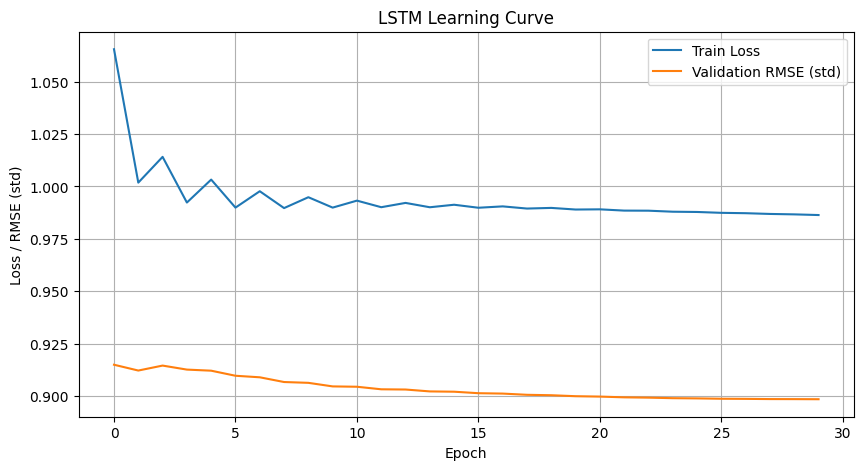

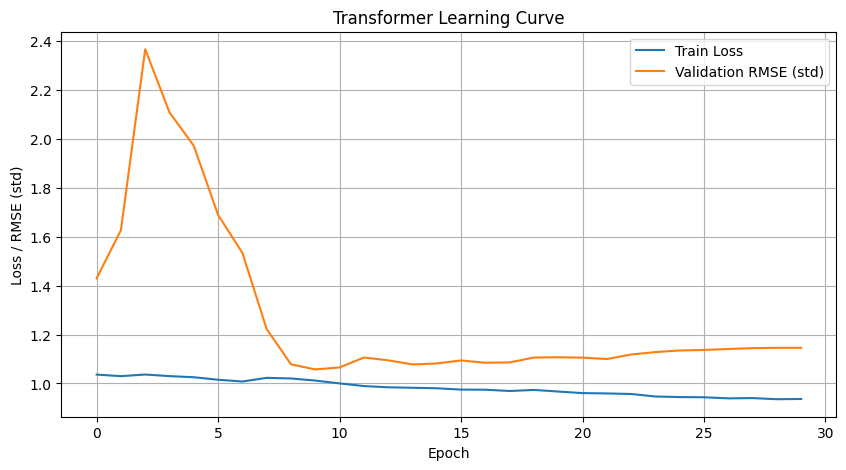

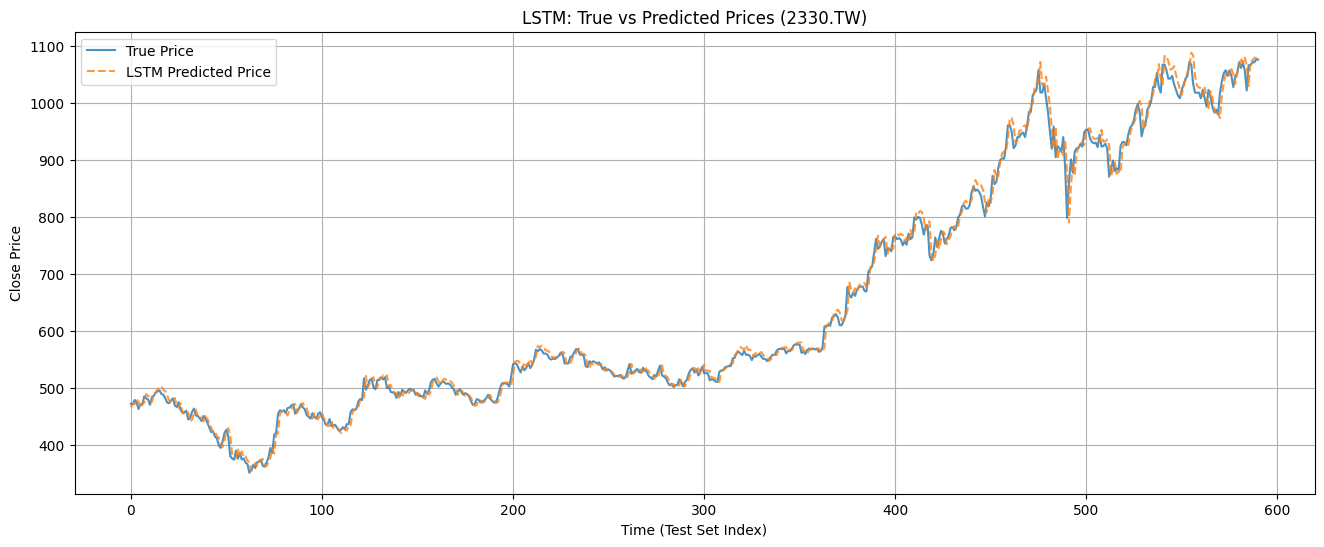

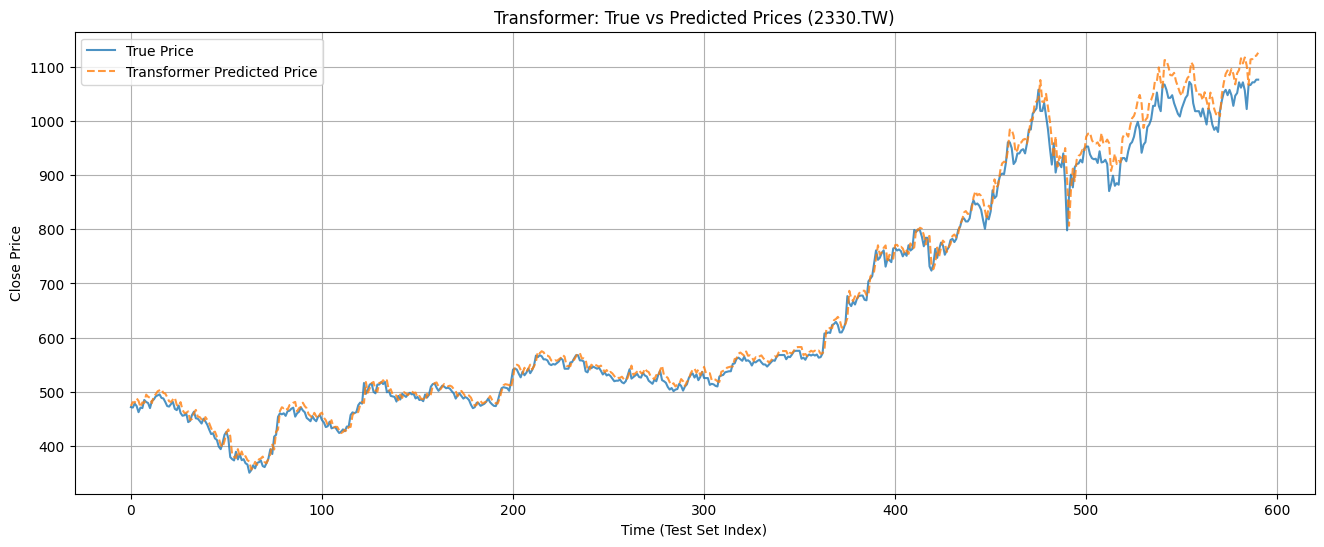


Generating Attention Heatmap...
Attention weights shape: torch.Size([64, 4, 30, 30])


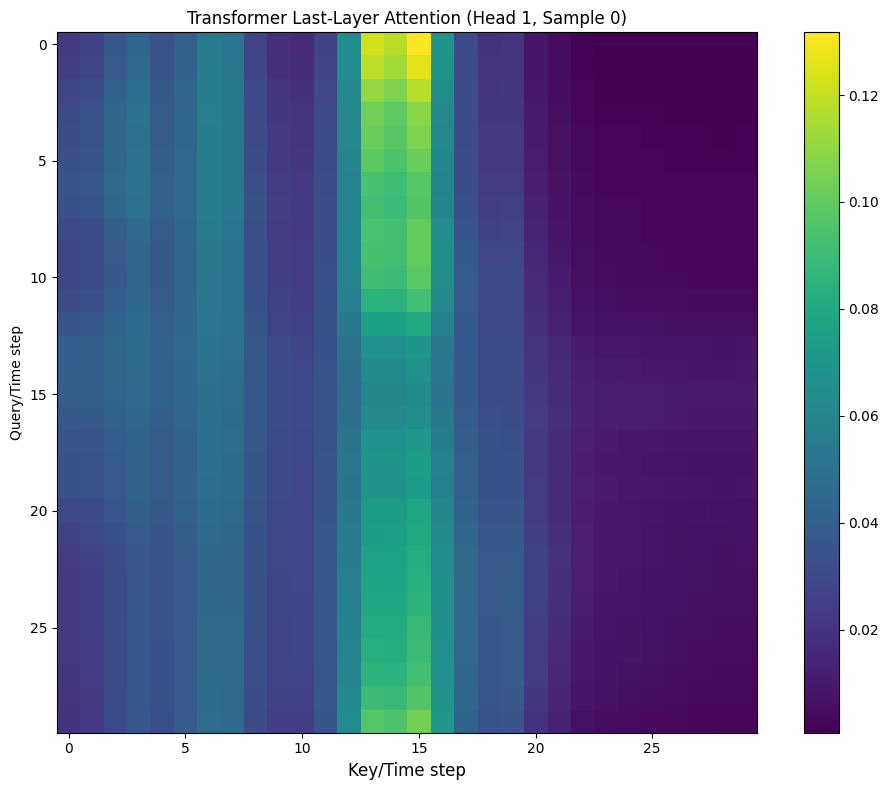

In [25]:
if results is not None:
    # --- 圖表 1: LSTM 學習曲線 ---
    plt.figure(figsize=(10, 5))
    plt.plot(results['LSTM']['history']['train_loss'], label='Train Loss')
    plt.plot(results['LSTM']['history']['val_rmse'], label='Validation RMSE (std)')
    plt.title('LSTM Learning Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss / RMSE (std)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- 圖表 2: Transformer 學習曲線 ---
    plt.figure(figsize=(10, 5))
    plt.plot(results['Transformer']['history']['train_loss'], label='Train Loss')
    plt.plot(results['Transformer']['history']['val_rmse'], label='Validation RMSE (std)')
    plt.title('Transformer Learning Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss / RMSE (std)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- 圖表 3: LSTM 真實 vs 預測 (價格尺度) ---
    plt.figure(figsize=(16, 6))
    plt.plot(results['LSTM']['true_prices'], label='True Price', alpha=0.8)
    plt.plot(results['LSTM']['pred_prices'], label='LSTM Predicted Price', linestyle='--', alpha=0.8)
    plt.title(f'LSTM: True vs Predicted Prices ({TICKER})')
    plt.xlabel('Time (Test Set Index)')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- 圖表 4: Transformer 真實 vs 預測 (價格尺度) ---
    plt.figure(figsize=(16, 6))
    plt.plot(results['Transformer']['true_prices'], label='True Price', alpha=0.8)
    plt.plot(results['Transformer']['pred_prices'], label='Transformer Predicted Price', linestyle='--', alpha=0.8)
    plt.title(f'Transformer: True vs Predicted Prices ({TICKER})')
    plt.xlabel('Time (Test Set Index)')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- 圖表 5: Transformer Attention Heatmap ---
    print("\nGenerating Attention Heatmap...")

    tr_model = results['Transformer']['model']
    tr_model.eval()

    if test_loader is not None and len(test_loader) > 0:
        X_sample_s, y_sample_s = next(iter(test_loader))
        X_sample_s = X_sample_s.to(DEVICE)

        with torch.no_grad():
            _ = tr_model(X_sample_s)

        if tr_model.attention_weights is not None:
            print(f"Attention weights shape: {tr_model.attention_weights.shape}")

            if len(tr_model.attention_weights.shape) == 4:
                single_attention_map = tr_model.attention_weights[0, 0, :, :].cpu().numpy()
            else:
                print("Error: Unexpected attention weights shape.")
                single_attention_map = None

            if single_attention_map is not None:
                fig, ax = plt.subplots(figsize=(10, 8))
                im = ax.imshow(single_attention_map, cmap='viridis')

                ticks = np.arange(0, LOOKBACK, 5)
                ax.set_xticks(ticks); ax.set_yticks(ticks)
                ax.set_xticklabels(ticks); ax.set_yticklabels(ticks)

                fig.colorbar(im, ax=ax)
                ax.set_xlabel('Key/Time step', fontsize=12)
                ax.set_ylabel('Query/Time step')
                ax.set_title(f'Transformer Last-Layer Attention (Head 1, Sample 0)')
                fig.tight_layout()
                plt.show()
        else:
            print("Could not retrieve attention weights.")
    else:
        print("Test loader is empty, skipping attention heatmap.")
else:
    print("Main experiment failed (results is None), skipping visualizations.")

11. 技術指標比較 (四個面向)

/tmp/ipython-input-560678109.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed



  Starting 4-Category Indicator Comparison (This will take time) 


--- Running group: Base Only ---
--- Running Experiment with 5 features ---
Requested Features: ['Open', 'High', 'Low', 'Close', 'Volume']
Detected MultiIndex columns, flattening to level 0.
Using 5 features: ['Open', 'High', 'Low', 'Close', 'Volume']
Data length after indicators/NaN drop: 6225
Total Samples: 6225 | Train/Val/Test (DF rows): 4980 / 622 / 623
Total Samples: 6225 | Train/Val/Test (DF rows): 4980 / 622 / 623


Train Sequences: 4951 | Val: 593 | Test: 594

=== Training LSTM ===


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


LSTM Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

LSTM Epoch 10/30 | LR: 1.00e-04 | Train Loss: 0.998533 | Val RMSE (std): 0.862005
LSTM Epoch 20/30 | LR: 1.00e-04 | Train Loss: 0.999953 | Val RMSE (std): 0.860418
LSTM Epoch 30/30 | LR: 1.00e-04 | Train Loss: 0.999338 | Val RMSE (std): 0.863337

--- LSTM Test Metrics (Standardized) ---
MSE (std): 0.953719
MAE (std): 0.695518
RMSE (std): 0.976585

--- LSTM Test Metrics (Price Scale) ---
MSE (price): 189.70
MAE (price): 9.14
RMSE (price): 13.77

=== Training Transformer ===


Transformer Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Transformer Epoch 05/30 | LR: 2.96e-04 | Train Loss: 1.013730 | Val RMSE (std): 1.264460
Transformer Epoch 10/30 | LR: 2.53e-04 | Train Loss: 0.993107 | Val RMSE (std): 1.210787
Transformer Epoch 15/30 | LR: 1.76e-04 | Train Loss: 0.999935 | Val RMSE (std): 0.928830
Transformer Epoch 20/30 | LR: 9.07e-05 | Train Loss: 0.990902 | Val RMSE (std): 0.901782
Transformer Epoch 25/30 | LR: 2.48e-05 | Train Loss: 0.975431 | Val RMSE (std): 0.879680


/tmp/ipython-input-560678109.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed

Transformer Epoch 30/30 | LR: 3.00e-04 | Train Loss: 0.967714 | Val RMSE (std): 0.882295

--- Transformer Test Metrics (Standardized) ---
MSE (std): 2.101810
MAE (std): 1.076125
RMSE (std): 1.449762

--- Transformer Test Metrics (Price Scale) ---
MSE (price): 581.30
MAE (price): 15.99
RMSE (price): 24.11

--- Running group: Base + trend ---
--- Running Experiment with 10 features ---
Requested Features: ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_5', 'SMA_20', 'MACD', 'MACD_SIGNAL', 'MACD_HIST']
Detected MultiIndex columns, flattening to level 0.
Using 10 features: ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_5', 'SMA_20', 'MACD', 'MACD_SIGNAL', 'MACD_HIST']
Data length after indicators/NaN drop: 6192
Total Samples: 6192 | Train/Val/Test (DF rows): 4953 / 619 / 620
Total Samples: 6192 | Train/Val/Test (DF rows): 4953 / 619 / 620
Train Sequences: 4924 | Val: 590 | Test: 591

=== Training LSTM ===



/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


LSTM Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

LSTM Epoch 10/30 | LR: 1.00e-04 | Train Loss: 0.995722 | Val RMSE (std): 0.864081
LSTM Epoch 20/30 | LR: 1.00e-04 | Train Loss: 0.989147 | Val RMSE (std): 0.864401
LSTM Epoch 30/30 | LR: 1.00e-04 | Train Loss: 0.987527 | Val RMSE (std): 0.870492

--- LSTM Test Metrics (Standardized) ---
MSE (std): 0.981379
MAE (std): 0.708110
RMSE (std): 0.990646

--- LSTM Test Metrics (Price Scale) ---
MSE (price): 196.54
MAE (price): 9.32
RMSE (price): 14.02

=== Training Transformer ===


Transformer Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Transformer Epoch 05/30 | LR: 2.96e-04 | Train Loss: 1.011903 | Val RMSE (std): 2.164360
Transformer Epoch 10/30 | LR: 2.53e-04 | Train Loss: 1.157152 | Val RMSE (std): 1.072302
Transformer Epoch 15/30 | LR: 1.76e-04 | Train Loss: 0.992196 | Val RMSE (std): 1.046504
Transformer Epoch 20/30 | LR: 9.07e-05 | Train Loss: 0.988010 | Val RMSE (std): 1.076651
Transformer Epoch 25/30 | LR: 2.48e-05 | Train Loss: 0.980528 | Val RMSE (std): 1.074862


/tmp/ipython-input-560678109.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed

Transformer Epoch 30/30 | LR: 3.00e-04 | Train Loss: 0.976416 | Val RMSE (std): 1.075472

--- Transformer Test Metrics (Standardized) ---
MSE (std): 1.894436
MAE (std): 1.031804
RMSE (std): 1.376385

--- Transformer Test Metrics (Price Scale) ---
MSE (price): 525.89
MAE (price): 15.21
RMSE (price): 22.93

--- Running group: Base + oscillator ---
--- Running Experiment with 6 features ---
Requested Features: ['Open', 'High', 'Low', 'Close', 'Volume', 'RSI_14']
Detected MultiIndex columns, flattening to level 0.
Using 6 features: ['Open', 'High', 'Low', 'Close', 'Volume', 'RSI_14']
Data length after indicators/NaN drop: 6224
Total Samples: 6224 | Train/Val/Test (DF rows): 4979 / 622 / 623
Total Samples: 6224 | Train/Val/Test (DF rows): 4979 / 622 / 623
Train Sequences: 4950 | Val: 593 | Test: 594

=== Training LSTM ===



/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


LSTM Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

LSTM Epoch 10/30 | LR: 1.00e-04 | Train Loss: 0.998496 | Val RMSE (std): 0.874531
LSTM Epoch 20/30 | LR: 1.00e-04 | Train Loss: 0.995966 | Val RMSE (std): 0.866603
LSTM Epoch 30/30 | LR: 1.00e-04 | Train Loss: 0.993930 | Val RMSE (std): 0.865324

--- LSTM Test Metrics (Standardized) ---
MSE (std): 0.951302
MAE (std): 0.694998
RMSE (std): 0.975347

--- LSTM Test Metrics (Price Scale) ---
MSE (price): 187.10
MAE (price): 9.09
RMSE (price): 13.68

=== Training Transformer ===


Transformer Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Transformer Epoch 05/30 | LR: 2.96e-04 | Train Loss: 1.017625 | Val RMSE (std): 1.002114
Transformer Epoch 10/30 | LR: 2.53e-04 | Train Loss: 1.013300 | Val RMSE (std): 1.717506
Transformer Epoch 15/30 | LR: 1.76e-04 | Train Loss: 1.036787 | Val RMSE (std): 1.201098
Transformer Epoch 20/30 | LR: 9.07e-05 | Train Loss: 0.985108 | Val RMSE (std): 1.170645
Transformer Epoch 25/30 | LR: 2.48e-05 | Train Loss: 0.974991 | Val RMSE (std): 1.176239


/tmp/ipython-input-560678109.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed

Transformer Epoch 30/30 | LR: 3.00e-04 | Train Loss: 0.968992 | Val RMSE (std): 1.178132

--- Transformer Test Metrics (Standardized) ---
MSE (std): 1.058827
MAE (std): 0.758287
RMSE (std): 1.028993

--- Transformer Test Metrics (Price Scale) ---
MSE (price): 216.16
MAE (price): 10.06
RMSE (price): 14.70

--- Running group: Base + volatility ---
--- Running Experiment with 6 features ---
Requested Features: ['Open', 'High', 'Low', 'Close', 'Volume', 'ROLL_STD_10']
Detected MultiIndex columns, flattening to level 0.
Using 6 features: ['Open', 'High', 'Low', 'Close', 'Volume', 'ROLL_STD_10']
Data length after indicators/NaN drop: 6216
Total Samples: 6216 | Train/Val/Test (DF rows): 4972 / 621 / 623
Total Samples: 6216 | Train/Val/Test (DF rows): 4972 / 621 / 623
Train Sequences: 4943 | Val: 592 | Test: 594

=== Training LSTM ===



/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


LSTM Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

LSTM Epoch 10/30 | LR: 1.00e-04 | Train Loss: 1.002540 | Val RMSE (std): 0.857885
LSTM Epoch 20/30 | LR: 1.00e-04 | Train Loss: 1.001416 | Val RMSE (std): 0.863331
LSTM Epoch 30/30 | LR: 1.00e-04 | Train Loss: 1.000219 | Val RMSE (std): 0.871087

--- LSTM Test Metrics (Standardized) ---
MSE (std): 0.958137
MAE (std): 0.694707
RMSE (std): 0.978845

--- LSTM Test Metrics (Price Scale) ---
MSE (price): 189.60
MAE (price): 9.13
RMSE (price): 13.77

=== Training Transformer ===


Transformer Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Transformer Epoch 05/30 | LR: 2.96e-04 | Train Loss: 1.001573 | Val RMSE (std): 0.948761
Transformer Epoch 10/30 | LR: 2.53e-04 | Train Loss: 1.010529 | Val RMSE (std): 0.938756
Transformer Epoch 15/30 | LR: 1.76e-04 | Train Loss: 1.002453 | Val RMSE (std): 0.933439
Transformer Epoch 20/30 | LR: 9.07e-05 | Train Loss: 0.992716 | Val RMSE (std): 0.926159
Transformer Epoch 25/30 | LR: 2.48e-05 | Train Loss: 0.991252 | Val RMSE (std): 0.933474


/tmp/ipython-input-560678109.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed

Transformer Epoch 30/30 | LR: 3.00e-04 | Train Loss: 0.986523 | Val RMSE (std): 0.937736

--- Transformer Test Metrics (Standardized) ---
MSE (std): 1.430666
MAE (std): 0.879663
RMSE (std): 1.196105

--- Transformer Test Metrics (Price Scale) ---
MSE (price): 324.66
MAE (price): 12.07
RMSE (price): 18.02

--- Running group: Base + volume ---
--- Running Experiment with 6 features ---
Requested Features: ['Open', 'High', 'Low', 'Close', 'Volume', 'VOL_MA_10']
Detected MultiIndex columns, flattening to level 0.
Using 6 features: ['Open', 'High', 'Low', 'Close', 'Volume', 'VOL_MA_10']
Data length after indicators/NaN drop: 6216
Total Samples: 6216 | Train/Val/Test (DF rows): 4972 / 621 / 623
Total Samples: 6216 | Train/Val/Test (DF rows): 4972 / 621 / 623
Train Sequences: 4943 | Val: 592 | Test: 594

=== Training LSTM ===



/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


LSTM Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

LSTM Epoch 10/30 | LR: 1.00e-04 | Train Loss: 1.009355 | Val RMSE (std): 0.880574
LSTM Epoch 20/30 | LR: 1.00e-04 | Train Loss: 1.001224 | Val RMSE (std): 0.887670
LSTM Epoch 30/30 | LR: 1.00e-04 | Train Loss: 0.999120 | Val RMSE (std): 0.898409

--- LSTM Test Metrics (Standardized) ---
MSE (std): 0.934192
MAE (std): 0.683101
RMSE (std): 0.966536

--- LSTM Test Metrics (Price Scale) ---
MSE (price): 182.22
MAE (price): 8.92
RMSE (price): 13.50

=== Training Transformer ===


Transformer Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Transformer Epoch 05/30 | LR: 2.96e-04 | Train Loss: 1.063232 | Val RMSE (std): 0.914804
Transformer Epoch 10/30 | LR: 2.53e-04 | Train Loss: 1.013276 | Val RMSE (std): 0.902847
Transformer Epoch 15/30 | LR: 1.76e-04 | Train Loss: 1.003774 | Val RMSE (std): 0.893286
Transformer Epoch 20/30 | LR: 9.07e-05 | Train Loss: 0.998390 | Val RMSE (std): 0.895567
Transformer Epoch 25/30 | LR: 2.48e-05 | Train Loss: 0.993992 | Val RMSE (std): 0.909351


/tmp/ipython-input-560678109.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed

Transformer Epoch 30/30 | LR: 3.00e-04 | Train Loss: 0.994360 | Val RMSE (std): 0.909227

--- Transformer Test Metrics (Standardized) ---
MSE (std): 1.240480
MAE (std): 0.817572
RMSE (std): 1.113768

--- Transformer Test Metrics (Price Scale) ---
MSE (price): 289.12
MAE (price): 11.40
RMSE (price): 17.00

--- Running group: Base + All ---
--- Running Experiment with 13 features ---
Requested Features: ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_5', 'SMA_20', 'MACD', 'MACD_SIGNAL', 'MACD_HIST', 'RSI_14', 'ROLL_STD_10', 'VOL_MA_10']
Detected MultiIndex columns, flattening to level 0.
Using 13 features: ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_5', 'SMA_20', 'MACD', 'MACD_SIGNAL', 'MACD_HIST', 'RSI_14', 'ROLL_STD_10', 'VOL_MA_10']
Data length after indicators/NaN drop: 6192
Total Samples: 6192 | Train/Val/Test (DF rows): 4953 / 619 / 620
Total Samples: 6192 | Train/Val/Test (DF rows): 4953 / 619 / 620
Train Sequences: 4924 | Val: 590 | Test: 591

=== Training LSTM ===



/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


LSTM Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

LSTM Epoch 10/30 | LR: 1.00e-04 | Train Loss: 0.990583 | Val RMSE (std): 0.881637
LSTM Epoch 20/30 | LR: 1.00e-04 | Train Loss: 0.985938 | Val RMSE (std): 0.887629
LSTM Epoch 30/30 | LR: 1.00e-04 | Train Loss: 0.981692 | Val RMSE (std): 0.897069

--- LSTM Test Metrics (Standardized) ---
MSE (std): 1.015388
MAE (std): 0.714569
RMSE (std): 1.007665

--- LSTM Test Metrics (Price Scale) ---
MSE (price): 198.75
MAE (price): 9.33
RMSE (price): 14.10

=== Training Transformer ===


Transformer Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Transformer Epoch 05/30 | LR: 2.96e-04 | Train Loss: 1.031807 | Val RMSE (std): 1.357272
Transformer Epoch 10/30 | LR: 2.53e-04 | Train Loss: 0.998075 | Val RMSE (std): 0.885442
Transformer Epoch 15/30 | LR: 1.76e-04 | Train Loss: 0.984339 | Val RMSE (std): 0.896666
Transformer Epoch 20/30 | LR: 9.07e-05 | Train Loss: 0.980828 | Val RMSE (std): 0.888259
Transformer Epoch 25/30 | LR: 2.48e-05 | Train Loss: 0.970147 | Val RMSE (std): 0.889679
Transformer Epoch 30/30 | LR: 3.00e-04 | Train Loss: 0.959896 | Val RMSE (std): 0.890246

--- Transformer Test Metrics (Standardized) ---
MSE (std): 1.120235
MAE (std): 0.746339
RMSE (std): 1.058412

--- Transformer Test Metrics (Price Scale) ---
MSE (price): 232.30
MAE (price): 9.95
RMSE (price): 15.24


--- Indicator Group Comparison (Price RMSE) ---
Feature Set     | LSTM RMSE    | Transformer RMSE
--------------------------------------------
Base            | 13.77        | 24.11          
Base + trend    | 14.02        | 22.93          
Base + 

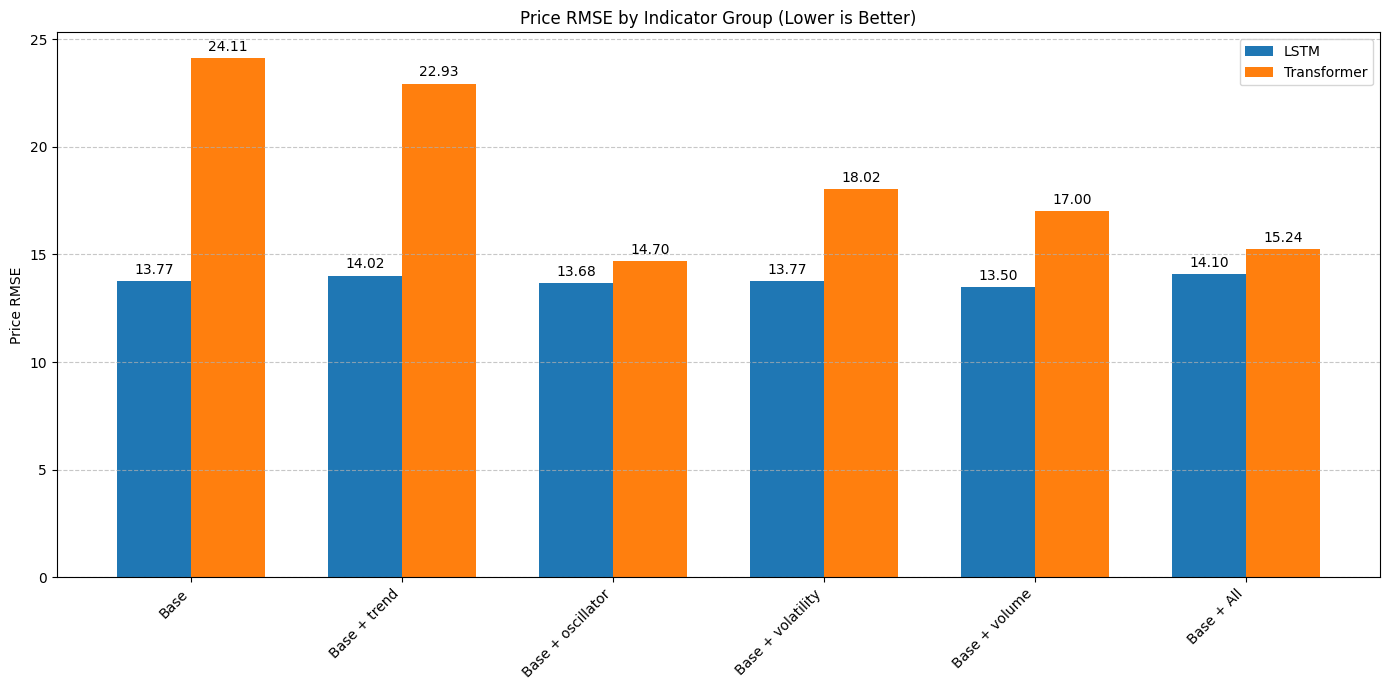

In [26]:
def compare_indicator_groups():
    group_results = {}
    base_features = IND_GROUPS['base']

    # 實驗 1: Base
    print('\n--- Running group: Base Only ---')
    res_base, _, _, _, _, _, _ = run_experiment(feature_set=base_features, epochs=EPOCHS)
    if res_base: group_results['Base'] = res_base
    else: print("Skipping Base experiment due to data error.")

    # 實驗 2-5: Base + 1
    for name in ['trend', 'oscillator', 'volatility', 'volume']:
        print(f'\n--- Running group: Base + {name} ---')
        featset = base_features + IND_GROUPS[name]
        res, _, _, _, _, _, _ = run_experiment(feature_set=featset, epochs=EPOCHS)
        if res: group_results[f'Base + {name}'] = res
        else: print(f"Skipping {name} experiment due to data error.")

    # 實驗 6: All
    all_feats = base_features + IND_GROUPS['trend'] + IND_GROUPS['oscillator'] + IND_GROUPS['volatility'] + IND_GROUPS['volume']
    print('\n--- Running group: Base + All ---')
    res_all, _, _, _, _, _, _ = run_experiment(feature_set=all_feats, epochs=EPOCHS)
    if res_all: group_results['Base + All'] = res_all
    else: print("Skipping All Features experiment due to data error.")

    if not group_results:
        print("\nNo experiments were successfully run. Cannot generate comparison chart.")
        return

    print("\n\n--- Indicator Group Comparison (Price RMSE) ---")

    names = list(group_results.keys())
    # 檢查，防止 'LSTM' 鍵不存在
    lstm_rmse = [group_results[n]['LSTM']['metrics_price']['rmse']
                 for n in names if 'LSTM' in group_results[n]]
    trans_rmse = [group_results[n]['Transformer']['metrics_price']['rmse']
                  for n in names if 'Transformer' in group_results[n]]

    # 確保名稱與結果匹配
    valid_names = [n for n in names if 'LSTM' in group_results[n] and 'Transformer' in group_results[n]]
    if len(valid_names) != len(names):
        print("Warning: Some experiments failed and will be excluded from the chart.")
        names = valid_names

    if not names:
        print("Error: No valid experiment results to plot.")
        return

    print(f"{'Feature Set':<15} | {'LSTM RMSE':<12} | {'Transformer RMSE':<15}")
    print("-" * 44)
    for i, name in enumerate(names):
        print(f"{name:<15} | {lstm_rmse[i]:<12.2f} | {trans_rmse[i]:<15.2f}")

    # 繪製比較圖
    x = np.arange(len(names))
    width = 0.35
    fig, ax = plt.subplots(figsize=(14, 7))
    rects1 = ax.bar(x - width/2, lstm_rmse, width, label='LSTM')
    rects2 = ax.bar(x + width/2, trans_rmse, width, label='Transformer')

    ax.set_ylabel('Price RMSE')
    ax.set_title('Price RMSE by Indicator Group (Lower is Better)')
    ax.set_xticks(x)
    ax.set_xticklabels(names, rotation=45, ha='right')
    ax.legend()
    ax.bar_label(rects1, padding=3, fmt='%.2f')
    ax.bar_label(rects2, padding=3, fmt='%.2f')
    fig.tight_layout()
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()

# --- 執行指標比較 ---
if results is not None:
    print("\n\n" + "="*50)
    print("  Starting 4-Category Indicator Comparison (This will take time) ")
    print("="*50 + "\n")
    compare_indicator_groups()
else:
    print("\nSkipping 4-Category Indicator Comparison because main experiment failed.")
